In [25]:
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow import keras


path = os.path.abspath("..")
filepath = "/data/AAPL.csv"

data = pd.read_csv(path + filepath, parse_dates=["Date"])

target = "Close" #close price

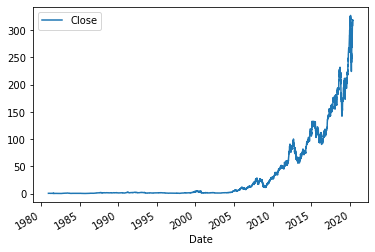

In [18]:
data.plot(x="Date", y="Close")

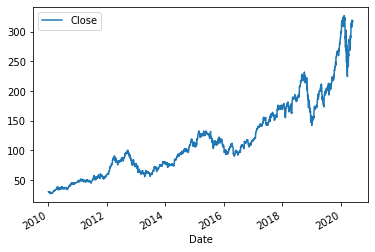

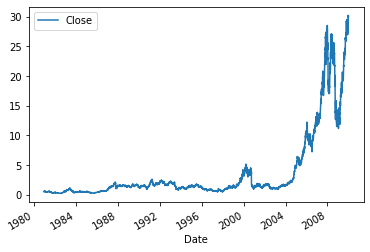

In [20]:
data[data["Date"] > "2010"].plot(x="Date", y="Close")
data[data["Date"] <= "2010"].plot(x="Date", y="Close")

## data prep

### cut time series

In [34]:
data_past_2010 = data[data["Date"] > "2010"].copy()

### change data types (not necessary)

In [35]:
data_past_2010.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

### train test split (keep sequence!)

In [36]:
cols = ["Date", target]

train_size = int(len(data_past_2010) * 0.9)

train = data_past_2010[cols].iloc[:train_size]
test = data_past_2010[cols].iloc[train_size:]

display("train shape: ", train.shape, "test shape: ", test.shape)

'train shape: '

(2357, 2)

'test shape: '

(262, 2)

### scale data

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler = scaler.fit(train[target].values.reshape(-1, 1))



train["Close_scaled"] = scaler.transform(train[target].values.reshape(-1, 1))
test["Close_scaled"] = scaler.transform(test[target].values.reshape(-1, 1))


In [38]:
train.dtypes

Date            datetime64[ns]
Close                  float64
Close_scaled           float64
dtype: object

In [39]:
train.describe()

,Close,Close_scaled
count,2357.000000,2.357000e+03
mean,102.637865,1.929348e-16
std,48.613227,1.000212e+00
min,27.435715,-1.547277e+00
25%,62.930000,-8.169853e-01
50%,96.099998,-1.345159e-01
75%,130.059998,5.642076e-01
max,232.070007,2.663053e+00


### create sequences (30 days)

In [104]:

def create_sequences(X, Y, TIME_STEPS):
    X_sequences, Y_sequences = [], []

    for i in range(len(X) - TIME_STEPS):
        seq_x = X.iloc[i: (i + TIME_STEPS)].to_numpy()
        seq_y = Y.iloc[i: (i + TIME_STEPS)]

        X_sequences.append(seq_x)
        Y_sequences.append(seq_y)

    return np.array(X_sequences), np.array(Y_sequences)


TIME_STEPS = 30

x_train, y_train = create_sequences(train[[target]], train[target], TIME_STEPS)
x_test, y_test = create_sequences(test[[target]], test[target], TIME_STEPS)



In [76]:
print(x_train.shape, y_train.shape)



(2327, 30, 1) (2327, 30)


In [82]:
x_train[0]

array([[30.572857],
       [30.625713],
       [30.138571],
       [30.082857],
       [30.282858],
       [30.015715],
       [29.674286],
       [30.092857],
       [29.918571],
       [29.418571],
       [30.719999],
       [30.247143],
       [29.724285],
       [28.25    ],
       [29.01    ],
       [29.42    ],
       [29.697144],
       [28.469999],
       [27.437143],
       [27.818571],
       [27.98    ],
       [28.461428],
       [27.435715],
       [27.922857],
       [27.731428],
       [28.027143],
       [27.874287],
       [28.381428],
       [28.625713],
       [29.057142]])

## create LSTM model

In [78]:
model = keras.Sequential()

model.add(keras.layers.LSTM(
    units=64,
    input_shape=(x_train.shape[1], x_train.shape[2])
))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(n=x_train.shape[1]))

model.add(keras.layers.LSTM(
    units=64,
    return_sequences=True
))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(
    units=x_train.shape[2]
)))

model.compile(loss="mae", optimizer="adam")


## train model

In [79]:
epochs = 10
batch_size = 32
validation_split = 0.1


history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    shuffle=False
)


Train on 2094 samples, validate on 233 samples
Epoch 1/10
2094/2094 [==============================] - 20s 10ms/sample - loss: 84.9373 - val_loss: 177.5428
Epoch 2/10
2094/2094 [==============================] - 9s 4ms/sample - loss: 76.1378 - val_loss: 172.0080
Epoch 3/10
2094/2094 [==============================] - 10s 5ms/sample - loss: 71.0526 - val_loss: 167.2235
Epoch 4/10
2094/2094 [==============================] - 10s 5ms/sample - loss: 66.3769 - val_loss: 162.6364
Epoch 5/10
2094/2094 [==============================] - 9s 4ms/sample - loss: 61.9159 - val_loss: 158.1996
Epoch 6/10
2094/2094 [==============================] - 9s 4ms/sample - loss: 57.7673 - val_loss: 153.9634
Epoch 7/10
2094/2094 [==============================] - 9s 4ms/sample - loss: 54.1466 - val_loss: 150.0579
Epoch 8/10
2094/2094 [==============================] - 9s 4ms/sample - loss: 50.9599 - val_loss: 146.3643
Epoch 9/10
2094/2094 [==============================] - 10s 5ms/sample - loss: 48.1234 - val_

## validate model

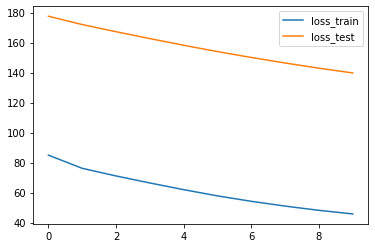

In [126]:

pd_losses = pd.DataFrame({"loss_train": history.history["loss"], "loss_test": history.history["val_loss"]})

pd_losses.plot(legend=True)

## make prediction

In [88]:
x_test_pred = model.predict(x_test)

In [90]:
x_test_pred.shape

(232, 30, 1)

In [106]:
x_pred = []
x_true = []

for i in range(30):
    
    x_pred_value = x_test_pred[len(x_test_pred)-1][i][0]
    x_pred.append(x_pred_value)
    
    x_true_value = x_test[len(x_test)-1][i][0]
    x_true.append(x_true_value)

    
    

In [111]:
a = pd.DataFrame({"true": x_true, "pred": x_pred})

In [113]:
a["diff"] = a["true"] - a["pred"]

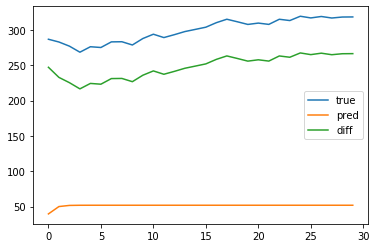

In [124]:
ax1 = a["true"].plot(legend=True)
ax2 = a["pred"].plot(legend=True,ax=ax1)
a["diff"].plot(legend=True, ax=ax2)